* Load the **houseprices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.


* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

# houseprices.columns
# print(houseprices.info())
# pd.set_option('display.max_columns', None)
# houseprices.head(10)

In [25]:
houseprices["lotfrontage"].fillna(houseprices["lotfrontage"].mean(), inplace=True)
houseprices["masvnrarea"].fillna(houseprices["masvnrarea"].mean(), inplace=True)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["kitchenqual"])], axis=1)
houseprices['garage_cars_area'] = houseprices['garagecars'] + houseprices['garagearea']
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["fence"])], axis=1)
houseprices['baths'] = houseprices.fullbath * houseprices.halfbath # 0.395
houseprices['sold_remodeled'] = houseprices.yearbuilt * houseprices.yearremodadd # 0.577
houseprices['sold_garage'] = houseprices.yearbuilt * houseprices.garageyrblt # 0.522
houseprices['bsm_first_sf'] = houseprices.totalbsmtsf * houseprices.firstflrsf # 0.54
houseprices['grade_living_area'] = houseprices.totrmsabvgrd  * houseprices.grlivarea # 0.648
houseprices['basement'] = houseprices.bsmtfullbath  * houseprices.bsmtfinsf1 # 0.346

# houseprices.corr()

* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.

The model is a good fit for the training set.



In [26]:

features = houseprices[['overallqual', 'totalbsmtsf', 'grade_living_area', 'garage_cars_area', 'TA', 'sold_remodeled']]
target = houseprices[['saleprice']]

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {}".format(features_train.shape[0]))
print("The number of observations in test set is {}".format(features_test.shape[0]))

features_train = sm.add_constant(features_train)

# We fit an OLS model using statsmodels
results = sm.OLS(target_train, features_train).fit()

# We print the summary results
print(results.summary())

# lrm.fit(features, target)
# np.set_printoptions(suppress=True)
# print('\nCoefficients: \n', lrm.coef_)
# print('\nIntercept: \n', lrm.intercept_)

# features_new = sm.add_constant(features)

# results = sm.OLS(target, features_new).fit()

# results.summary()

The number of observations in training set is 1168
The number of observations in test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     630.2
Date:                Fri, 01 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:47:21   Log-Likelihood:                -13980.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1161   BIC:                         2.801e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

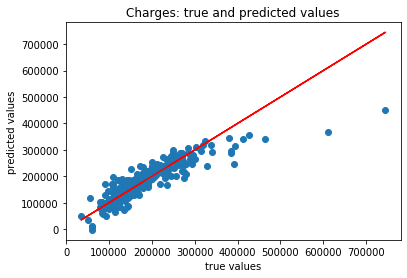

Mean absolute error of the prediction is: 25281.842280486784
Mean squared error of the prediction is: [6.99489279e+09 3.55523512e+10 6.79884520e+09 8.60350050e+09
 1.54702914e+10 6.72922014e+09 1.00720987e+10 2.19222097e+10
 7.18756590e+09 3.32329626e+10 1.54731328e+10 6.73466872e+09
 1.73389964e+10 2.04240963e+10 9.34078792e+09 1.51088723e+10
 7.18891829e+09 7.79592594e+09 7.66166324e+09 6.71646194e+09
 4.03249063e+10 8.19165523e+09 6.74573093e+09 2.21361360e+10
 7.21859784e+09 6.71896944e+09 7.46684287e+09 7.60788973e+09
 6.94009356e+09 7.82059215e+10 1.22327452e+10 1.07210251e+10
 7.92149673e+09 1.76528339e+10 8.11733770e+09 1.48924378e+10
 1.71976821e+10 7.26227203e+09 8.27458025e+09 2.25285398e+10
 8.52749915e+09 7.85941341e+09 1.03501004e+10 6.83880832e+09
 7.40140288e+09 7.23108658e+09 1.04520794e+10 1.49612187e+10
 1.52400656e+10 8.90353959e+09 6.98714931e+09 7.45662344e+09
 7.05967425e+09 8.72390034e+09 7.44523352e+09 6.97493446e+09
 7.56052186e+09 1.62948262e+10 3.17129481e+1

In [29]:
features_test = sm.add_constant(features_test)

# We are making predictions here
target_preds = results.predict(features_test)

plt.scatter(target_test, target_preds)
plt.plot(target_test, target_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target_test, target_preds)))
print("Mean squared error of the prediction is: {}".format(mse(target_test, target_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(target_test, target_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target_test - target_preds) / target_test)) * 100))


* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.